# Example Notebook

**You can download this Jupyter Notebook via the download button at the top of this page.**

In this Jupyter Notebook, we demonstrate the following operations using `sarxarray`:

- Load an SLC stack in binary format into a `xarray.Dataset` object;
- Append lat and lon coordinates to the loaded stack;
- Create an MRM of a subset of the SLC stack;
- Apply common SAR processings to the SLC stack;
- Export the selection results in Zarr format


## Setup

### Data preparation

We use a corregisterred and georeferenced [Sentinel-1 interferogram stack over Amsterdam](https://figshare.com/ndownloader/files/41012180) as an example dataset. Please download the data and unzip it locally. 

### Environment setup
For the python environment setup, we assume you already installed SARXarray following the installation guide.

Some extra python dependencies are required to execute this notebook. You can install the extra python dependencies by:
```sh
pip install sarxarray[demo]
```

After installation, execute the notebook in a JupyterLab session, which can be started by running `jupyterlab` command in your command line:

```bash
jupyter-lab
```

A new tab will be opened in your default browser to execute this notebook.

## Data loading

In [1]:
import numpy as np
from pathlib import Path
import sarxarray

We will load the interferogram stack, which has been corregistered and saved as binary files. We assume the shape and data type is known.

In [2]:
# Path to the interferogram dataset
path = Path('../../../data/nl_amsterdam_s1_asc_t088')

# Make a list of SLCs to read
f_slc = 'cint_srd.raw'
list_slcs = [p for p in path.rglob('*_cint_srd.raw')]
list_slcs.sort()

# Metadata of the stack, assume known.
shape=(2000, 4000)

# Define reading chunks
reading_chunks = (500,500)

In [3]:
# Check the list of SLCs
print(list_slcs)

[PosixPath('../../../data/nl_amsterdam_s1_asc_t088/20180920_cint_srd.raw'), PosixPath('../../../data/nl_amsterdam_s1_asc_t088/20180926_cint_srd.raw'), PosixPath('../../../data/nl_amsterdam_s1_asc_t088/20181002_cint_srd.raw'), PosixPath('../../../data/nl_amsterdam_s1_asc_t088/20181008_cint_srd.raw'), PosixPath('../../../data/nl_amsterdam_s1_asc_t088/20181014_cint_srd.raw'), PosixPath('../../../data/nl_amsterdam_s1_asc_t088/20181020_cint_srd.raw'), PosixPath('../../../data/nl_amsterdam_s1_asc_t088/20181026_cint_srd.raw'), PosixPath('../../../data/nl_amsterdam_s1_asc_t088/20181101_cint_srd.raw'), PosixPath('../../../data/nl_amsterdam_s1_asc_t088/20181107_cint_srd.raw'), PosixPath('../../../data/nl_amsterdam_s1_asc_t088/20181113_cint_srd.raw')]


Use `from_binary` to load the stack:

In [4]:
# Load complex data
stack = sarxarray.from_binary(list_slcs, shape, dtype=np.complex64, chunks=reading_chunks)

print(stack)

<xarray.Dataset>
Dimensions:    (azimuth: 2000, range: 4000, time: 10)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range      (range) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>


## Append georeferenced coordinates

The `sarxarray` is implemented as an extension of `Xarray.Dataset`, which means we can modify the `stack` variable as a normal `Dataset` objet. For example, we can append geo-refrenced coordinates to the loaded stack.

In [5]:
# Geo-referenced coordinates
f_lat = [path / 'lat.raw']
f_lon = [path / 'lon.raw']

In [6]:
# Load coordinates
lat = sarxarray.from_binary(
    f_lat, shape, vlabel="lat", dtype=np.float32, chunks=reading_chunks
)
lon = sarxarray.from_binary(
    f_lon, shape, vlabel="lon", dtype=np.float32, chunks=reading_chunks
)
stack = stack.assign_coords(
    lat=(("azimuth", "range"), lat.squeeze().lat.data),
    lon=(("azimuth", "range"), lon.squeeze().lon.data),
)

In [7]:
print(stack)

<xarray.Dataset>
Dimensions:    (azimuth: 2000, range: 4000, time: 10)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range      (range) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    lat        (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>


## Common SAR operations

Some common SAR operations are supported by SARXarray

### Multi-Looking

We apply a `(1, 2)` multi-look to the loaded stack. As a result the size of the output will be `(2000, 2000)`. 

In [8]:
stack_multilook = stack.slcstack.multi_look((1,2))
print(stack_multilook)

<xarray.Dataset>
Dimensions:    (azimuth: 2000, range: 2000, time: 10)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range      (range) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    lat        (azimuth, range) float32 dask.array<chunksize=(500, 250), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(500, 250), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(500, 250, 10), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(500, 250, 10), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(500, 250, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean


### Mean Reflection Map (MRM) 

In [9]:
mrm = stack_multilook.slcstack.mrm()
print(mrm)

<xarray.DataArray 'amplitude' (azimuth: 2000, range: 2000)>
dask.array<mean_agg-aggregate, shape=(2000, 2000), dtype=float32, chunksize=(500, 250), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
    lat      (azimuth, range) float32 dask.array<chunksize=(500, 250), meta=np.ndarray>
    lon      (azimuth, range) float32 dask.array<chunksize=(500, 250), meta=np.ndarray>


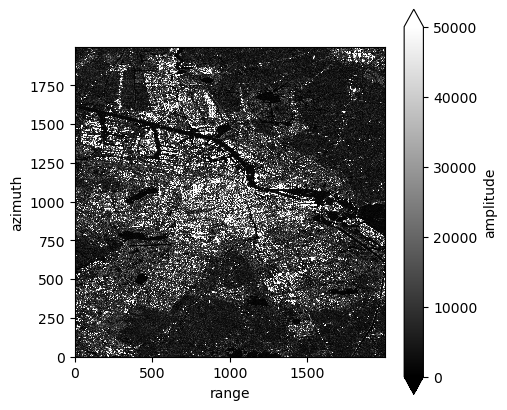

In [10]:
# Visualize
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches((5,5))
ax.imshow(mrm)
im = mrm.plot(ax=ax, robust=True, cmap='gray')
im.set_clim([0, 50000])

### Select coherent pixels
One can select the coherent pixels by `point_selection` function. For example select pixels with `amplitude_dispersion` lower than `0.2`.

In [11]:
# Select a subset
stack_subset = stack.sel(azimuth=range(100,1800), range=range(1000,3000))

# Perform point selection
stm = stack_subset.slcstack.point_selection(threshold=0.20, method="amplitude_dispersion")

print(stm)

<xarray.Dataset>
Dimensions:    (time: 10, space: 78582)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    lat        (space) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    lon        (space) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    azimuth    (space) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    range      (space) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
Dimensions without coordinates: space
Data variables:
    complex    (space, time) complex64 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    amplitude  (space, time) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    phase      (space, time) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean


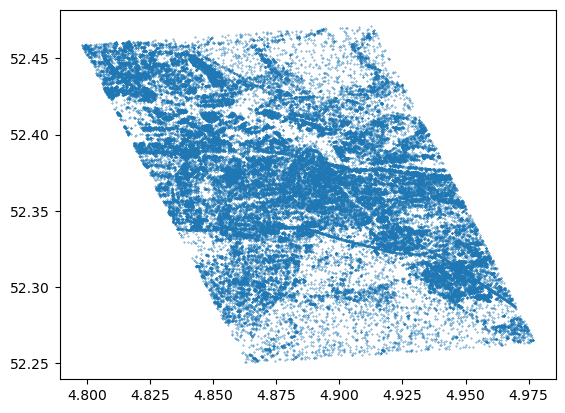

In [12]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
plt.scatter(stm.lon.data, stm.lat.data, s=0.1)

## Export results

The selected points can be saved to a `Zarr` storage.

In [13]:
# Export to Zarr
stm.to_zarr("stm.zarr", mode="w")

And can be read by `xr.open_zarr`

In [14]:
# Load exported STM in Zarr
import xarray as xr
stm_read = xr.open_zarr("stm.zarr")
print(stm_read)

<xarray.Dataset>
Dimensions:    (space: 78582, time: 10)
Coordinates:
    azimuth    (space) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat        (space) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    lon        (space) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    range      (space) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    complex    (space, time) complex64 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    phase      (space, time) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean
